# 1.32b: Single Token Trajectory Analysis

Examining the motion of a single dead token through 64D lattice space over the course of training. This is a proof-of-concept to understand individual token dynamics before scaling up to statistical analysis of many tokens.

## Questions

1. Is the token's motion a random walk, directed motion, or something else?
2. Which dimensions are active vs frozen?
3. Does the token wander outward, inward, or oscillate around a point?
4. How efficient is the motion (net displacement vs total path length)?

## Approach

- Pick one token at random from the dead token population
- Compute cumulative position over time (starting from origin)
- Visualize: per-dimension trajectories, distance from origin, path efficiency

## Parameters

In [1]:
RANDOM_SEED = 42
DPI = 200
COLORMAP = 'inferno'

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Lattice Displacements

In [4]:
tensor_path = Path('../tensors/Thimble/1.31c_delta_W_prime_dead.safetensors')
data = load_file(str(tensor_path))
delta_W_prime_dead = data['delta_W_prime'].to(torch.float32).to(device)

print(f"Loaded delta_W_prime_dead: {delta_W_prime_dead.shape}")  # [6000, 3699, 64]
num_steps, num_tokens, num_dims = delta_W_prime_dead.shape
print(f"Steps: {num_steps}, Tokens: {num_tokens}, Dimensions: {num_dims}")

Loaded delta_W_prime_dead: torch.Size([6000, 3699, 64])
Steps: 6000, Tokens: 3699, Dimensions: 64


## Select Random Token

In [5]:
np.random.seed(RANDOM_SEED)
token_id = np.random.randint(0, num_tokens)

print(f"Selected token ID: {token_id}")

Selected token ID: 3174


## Extract Token Trajectory

In [6]:
# Displacements for this token at each timestep: [6000, 64]
token_displacements = delta_W_prime_dead[:, token_id, :].cpu().numpy()

# Cumulative position (starting from origin)
token_position = np.cumsum(token_displacements, axis=0)  # [6000, 64]

print(f"Token displacements shape: {token_displacements.shape}")
print(f"Token position shape: {token_position.shape}")

Token displacements shape: (6000, 64)
Token position shape: (6000, 64)


## Compute Path Statistics

In [7]:
# Distance from origin at each timestep (L2 norm)
distance_from_origin = np.linalg.norm(token_position, axis=1)  # [6000]

# Step size at each timestep (L2 norm of displacement)
step_size = np.linalg.norm(token_displacements, axis=1)  # [6000]

# Total path length (sum of step sizes)
total_path_length = np.sum(step_size)

# Net displacement (final distance from origin)
net_displacement = distance_from_origin[-1]

# Path efficiency: net displacement / total path length
# (1.0 = perfectly straight, 0.0 = pure wandering)
path_efficiency = net_displacement / total_path_length if total_path_length > 0 else 0

print(f"Total path length: {total_path_length:.2f} cells")
print(f"Net displacement: {net_displacement:.2f} cells")
print(f"Path efficiency: {path_efficiency:.4f}")

Total path length: 7939352576.00 cells
Net displacement: 4480713728.00 cells
Path efficiency: 0.5644


## Plot 1: Distance from Origin Over Time

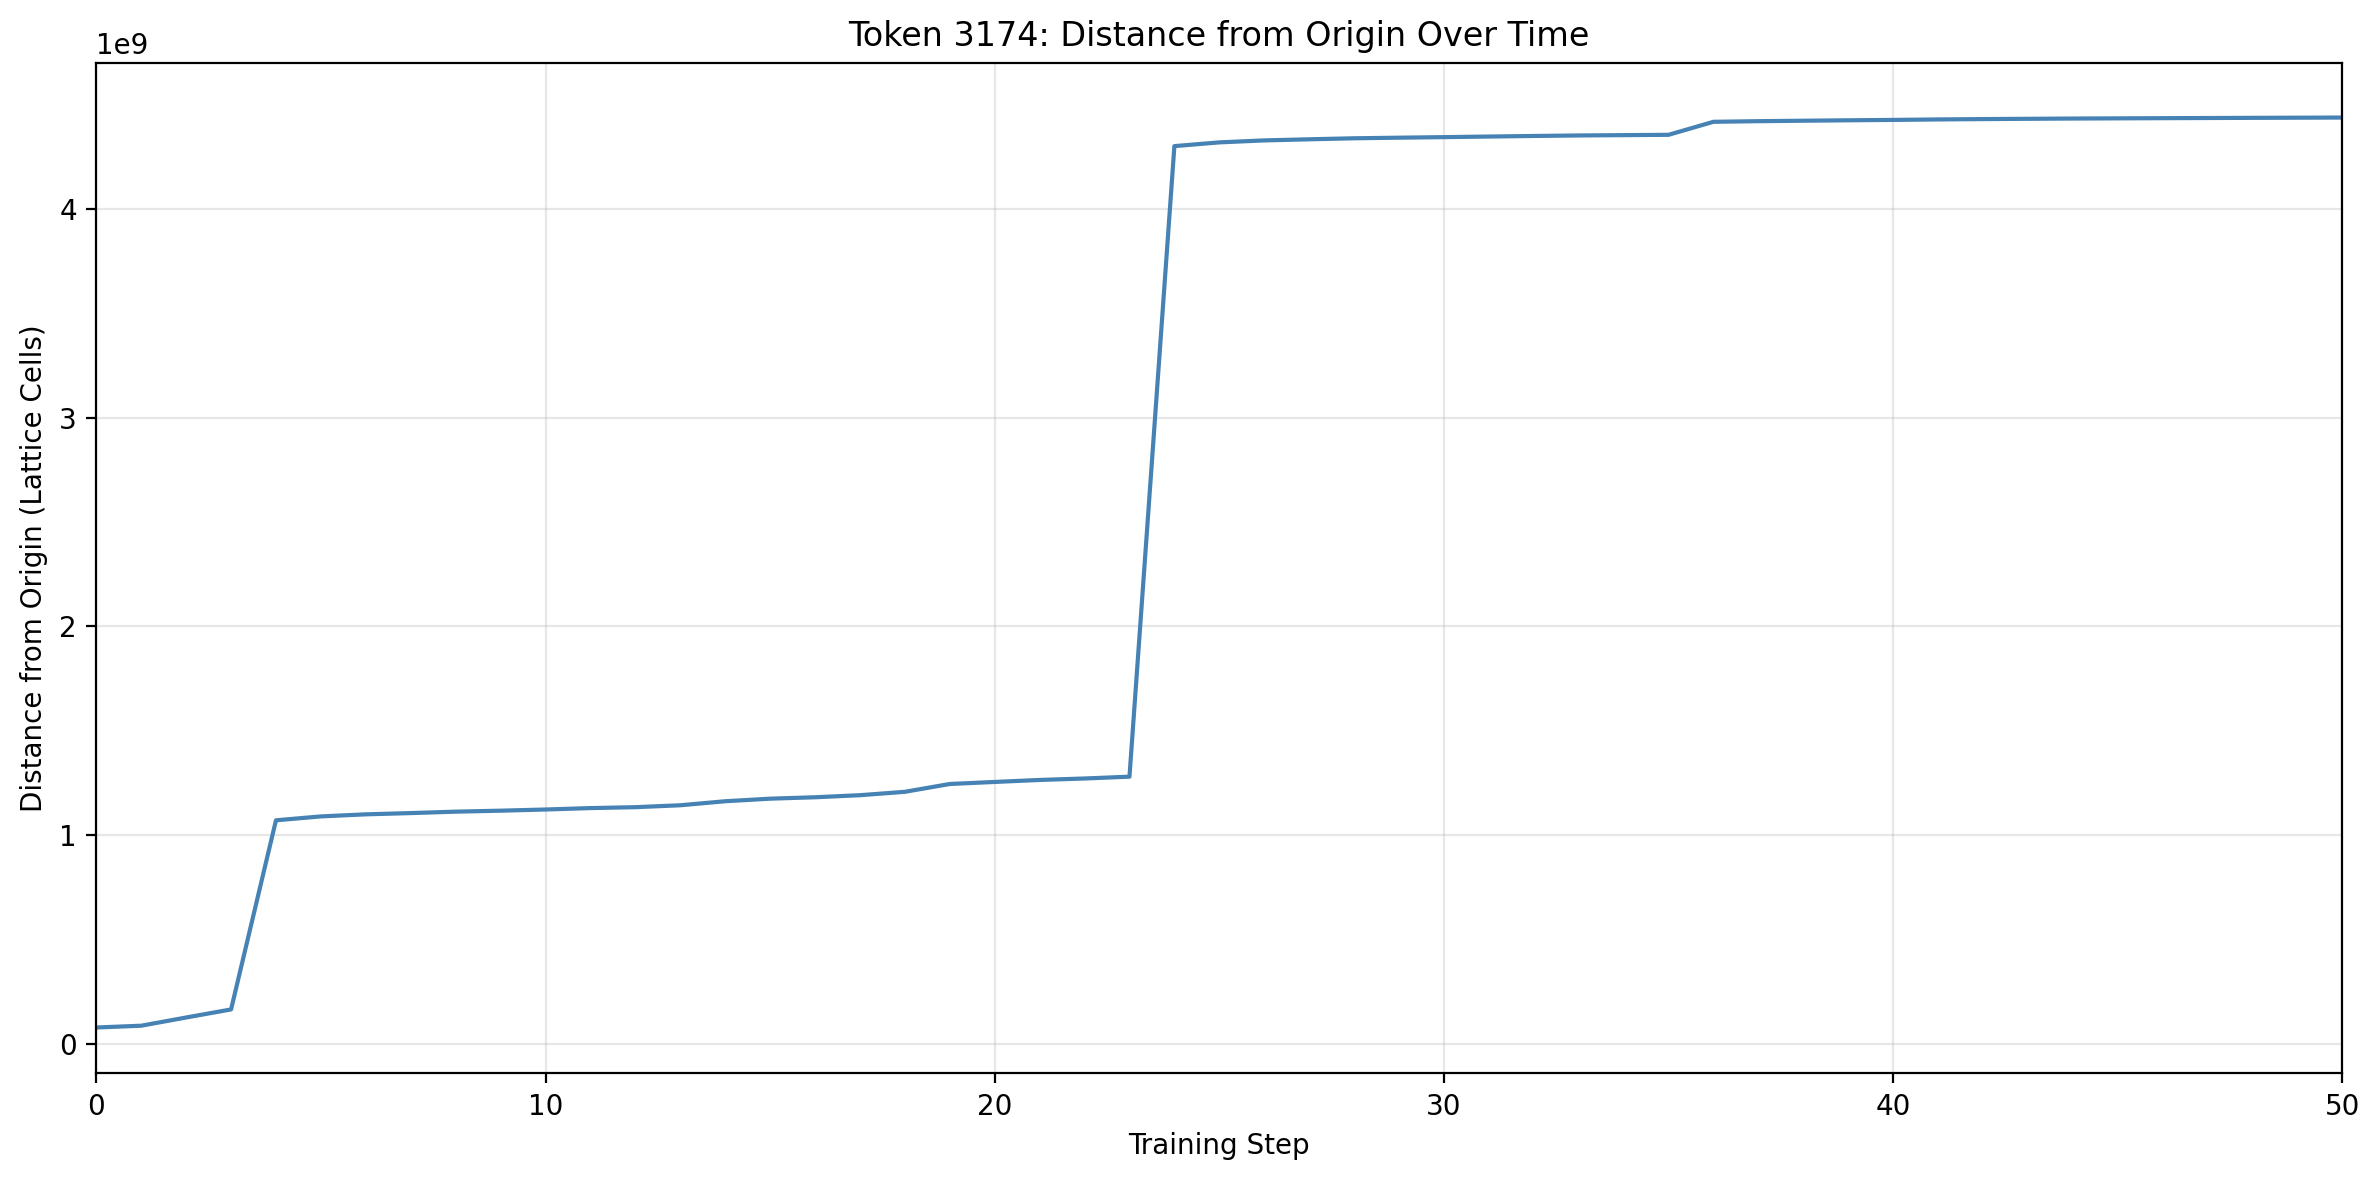

In [15]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

ax.plot(distance_from_origin, color='steelblue', linewidth=1.5)

ax.set_xlabel('Training Step')
ax.set_ylabel('Distance from Origin (Lattice Cells)')
ax.set_title(f'Token {token_id}: Distance from Origin Over Time')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 50)

plt.tight_layout()
plt.show()

## Plot 2: Step Size Over Time (L2 Norm)

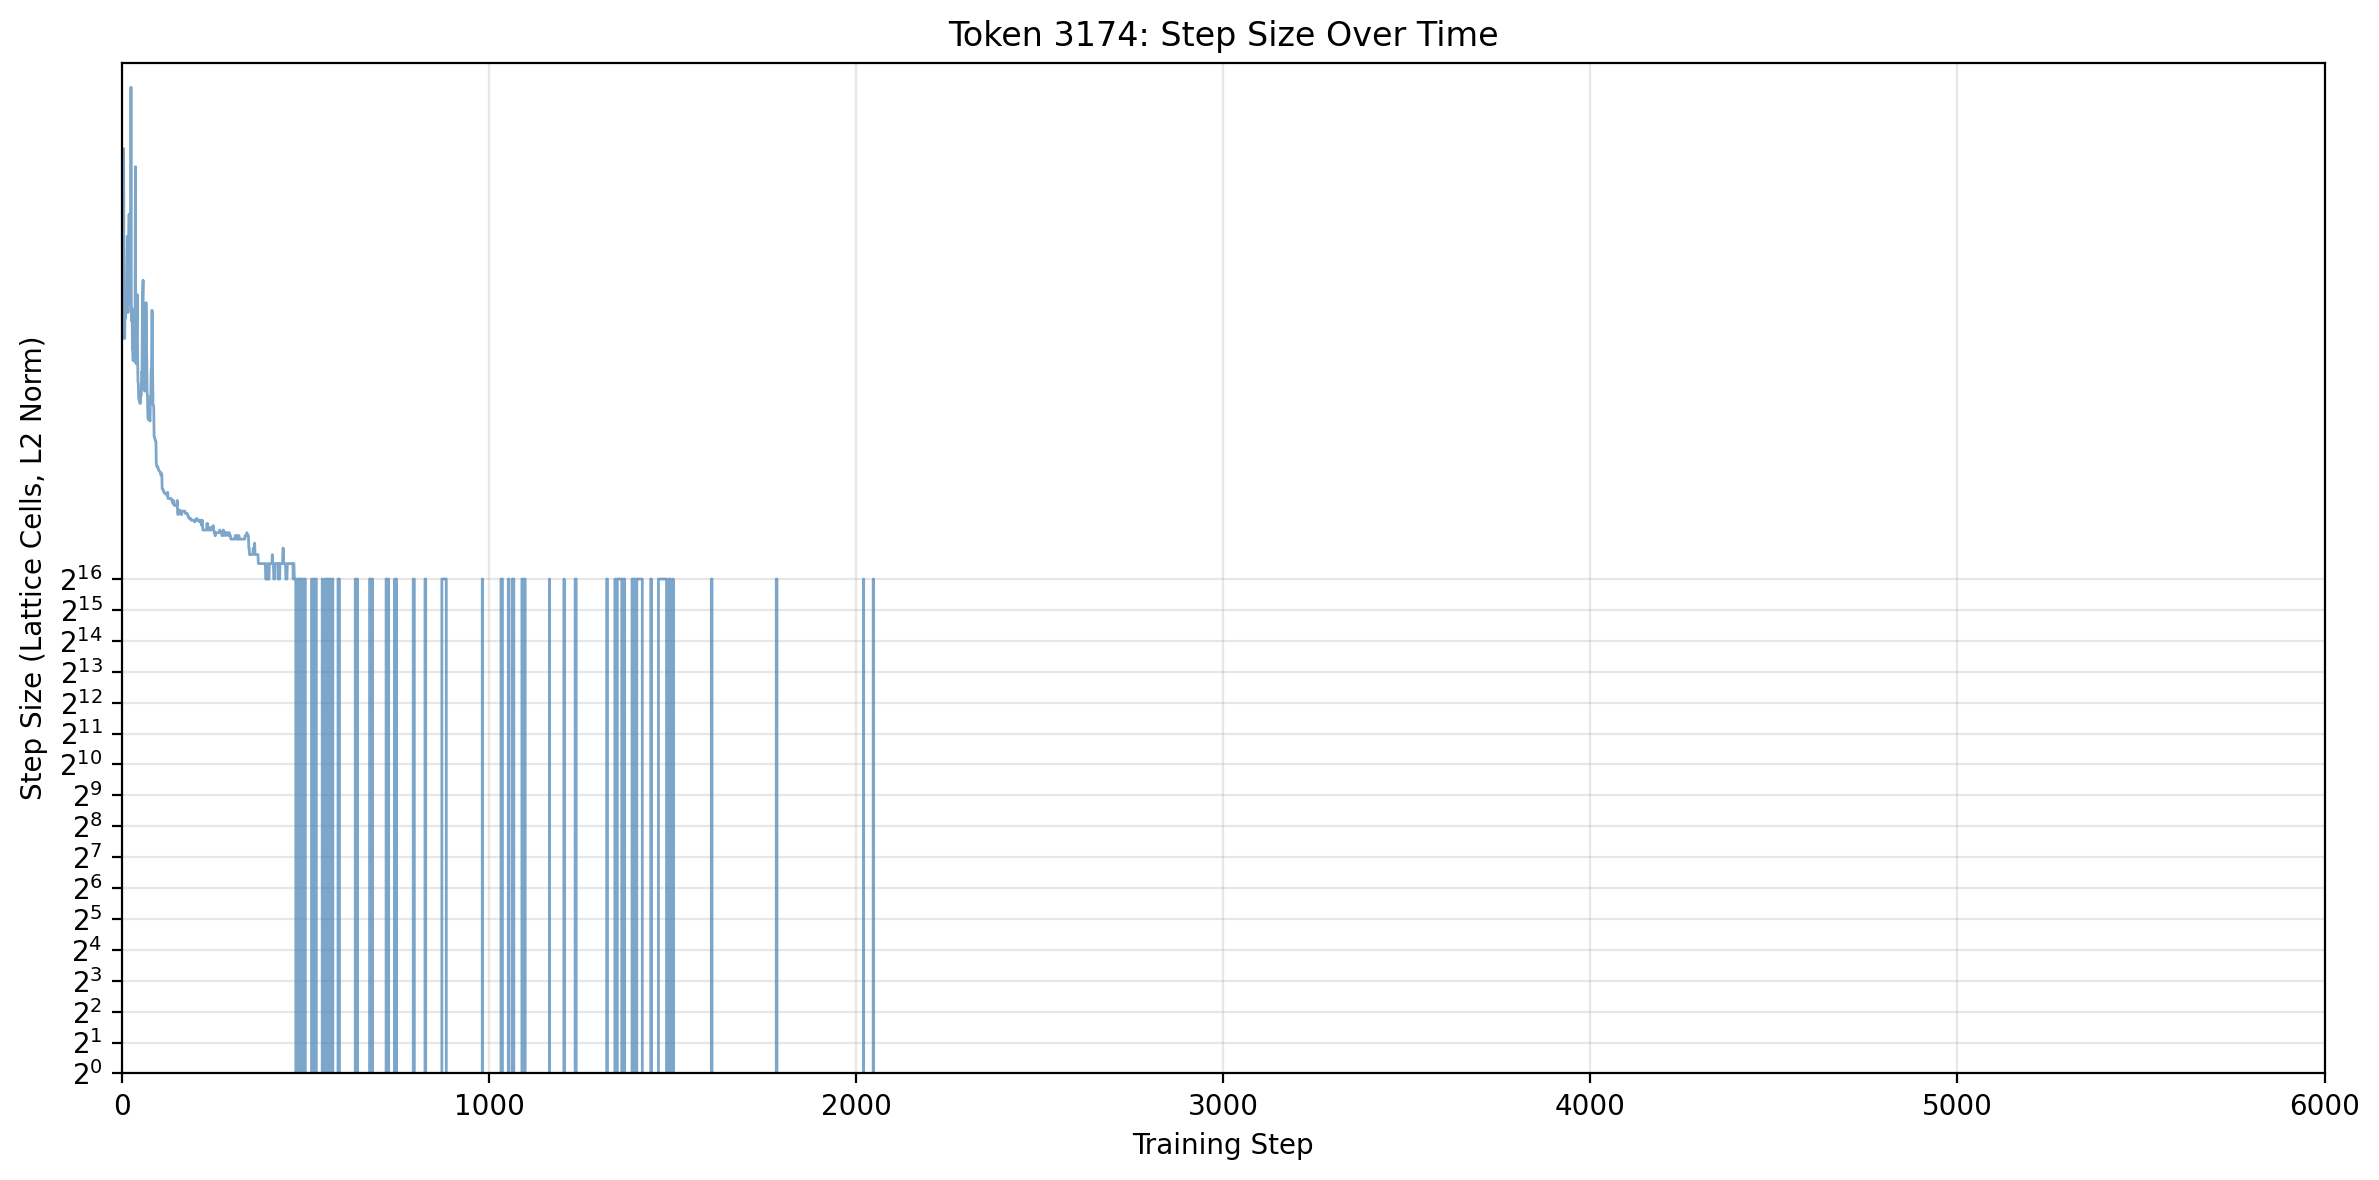

In [9]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

ax.plot(step_size, color='steelblue', linewidth=1, alpha=0.7)

ax.set_xlabel('Training Step')
ax.set_ylabel('Step Size (Lattice Cells, L2 Norm)')
ax.set_title(f'Token {token_id}: Step Size Over Time')
ax.set_yscale('log', base=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, num_steps)

# Set y-ticks at powers of 2
y_powers = np.arange(0, 17)
ax.set_yticks(2.0 ** y_powers)
ax.set_yticklabels([f'$2^{{{p}}}$' for p in y_powers])

plt.tight_layout()
plt.show()

## Plot 3: Per-Dimension Trajectories (First 16 Dimensions)

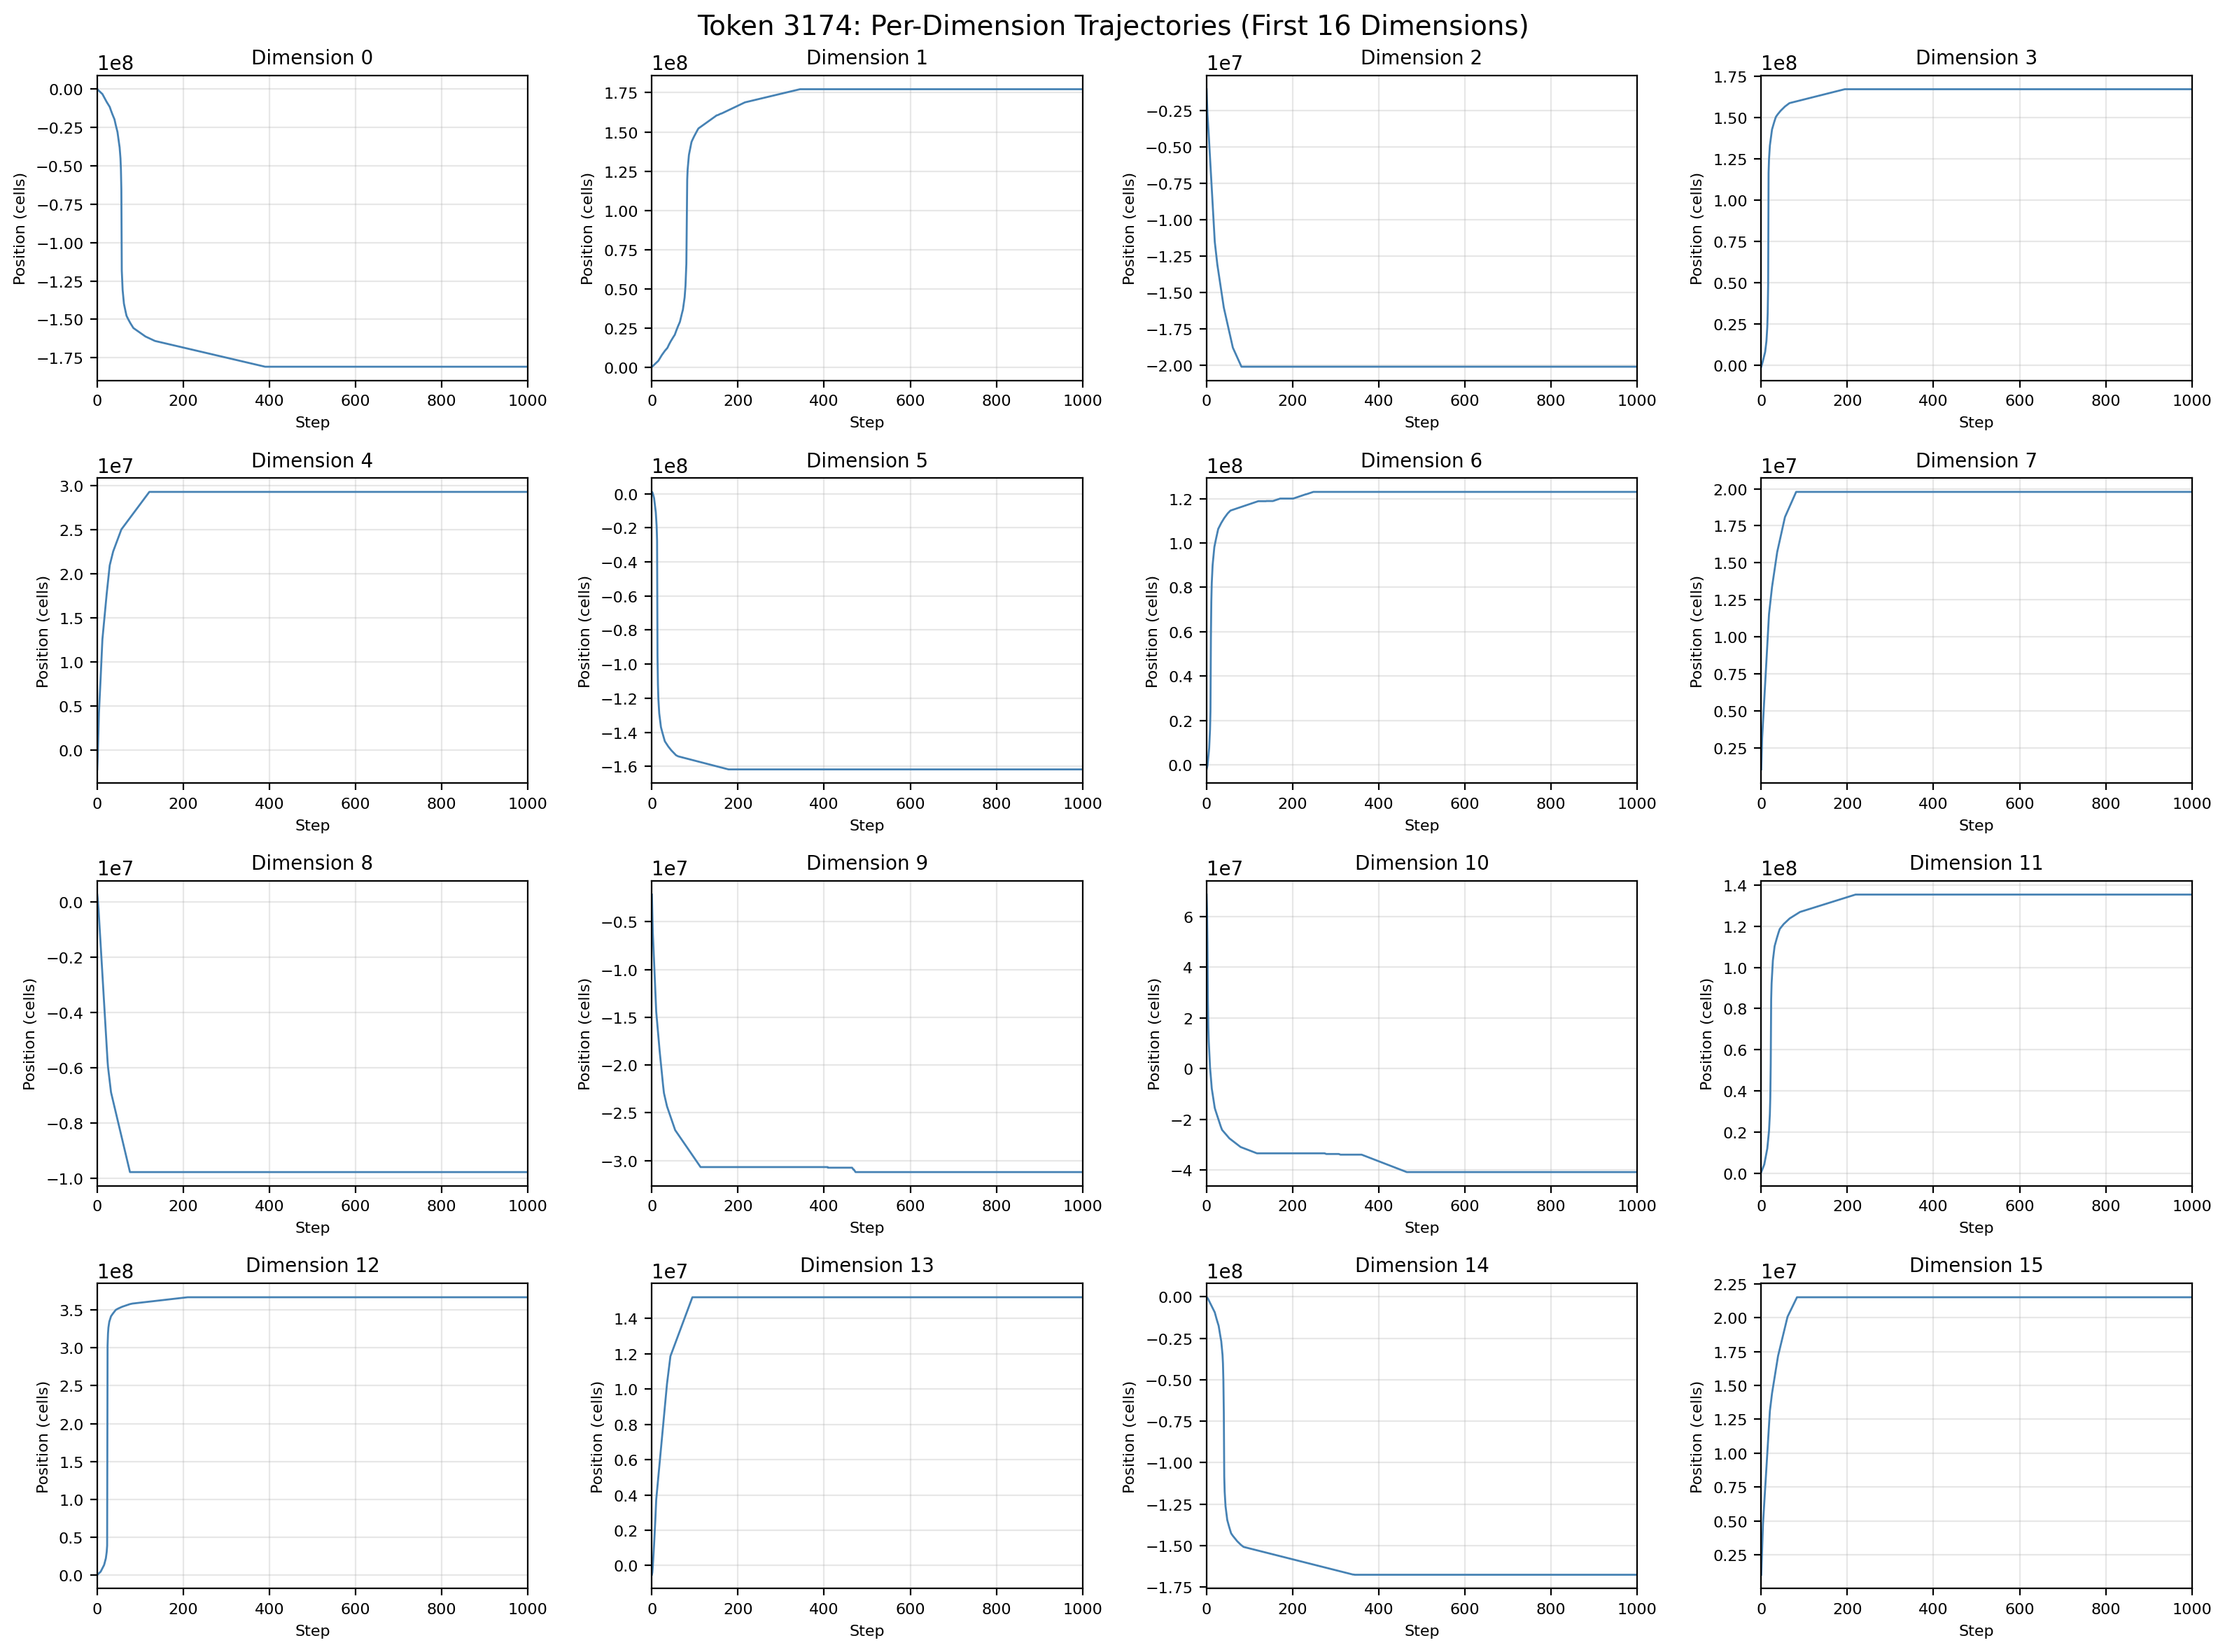

In [13]:
# Show first 16 dimensions to keep plot readable
num_dims_to_plot = 16

fig, axes = plt.subplots(4, 4, figsize=(16, 12), dpi=DPI)
axes = axes.flatten()

for i in range(num_dims_to_plot):
    axes[i].plot(token_position[:, i], color='steelblue', linewidth=1)
    axes[i].set_title(f'Dimension {i}', fontsize=10)
    axes[i].set_xlabel('Step', fontsize=8)
    axes[i].set_ylabel('Position (cells)', fontsize=8)
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(labelsize=8)
    axes[i].set_xlim(0, 1000)

plt.suptitle(f'Token {token_id}: Per-Dimension Trajectories (First 16 Dimensions)', fontsize=14)
plt.tight_layout()
plt.show()

## Plot 4: Dimension Activity Heatmap

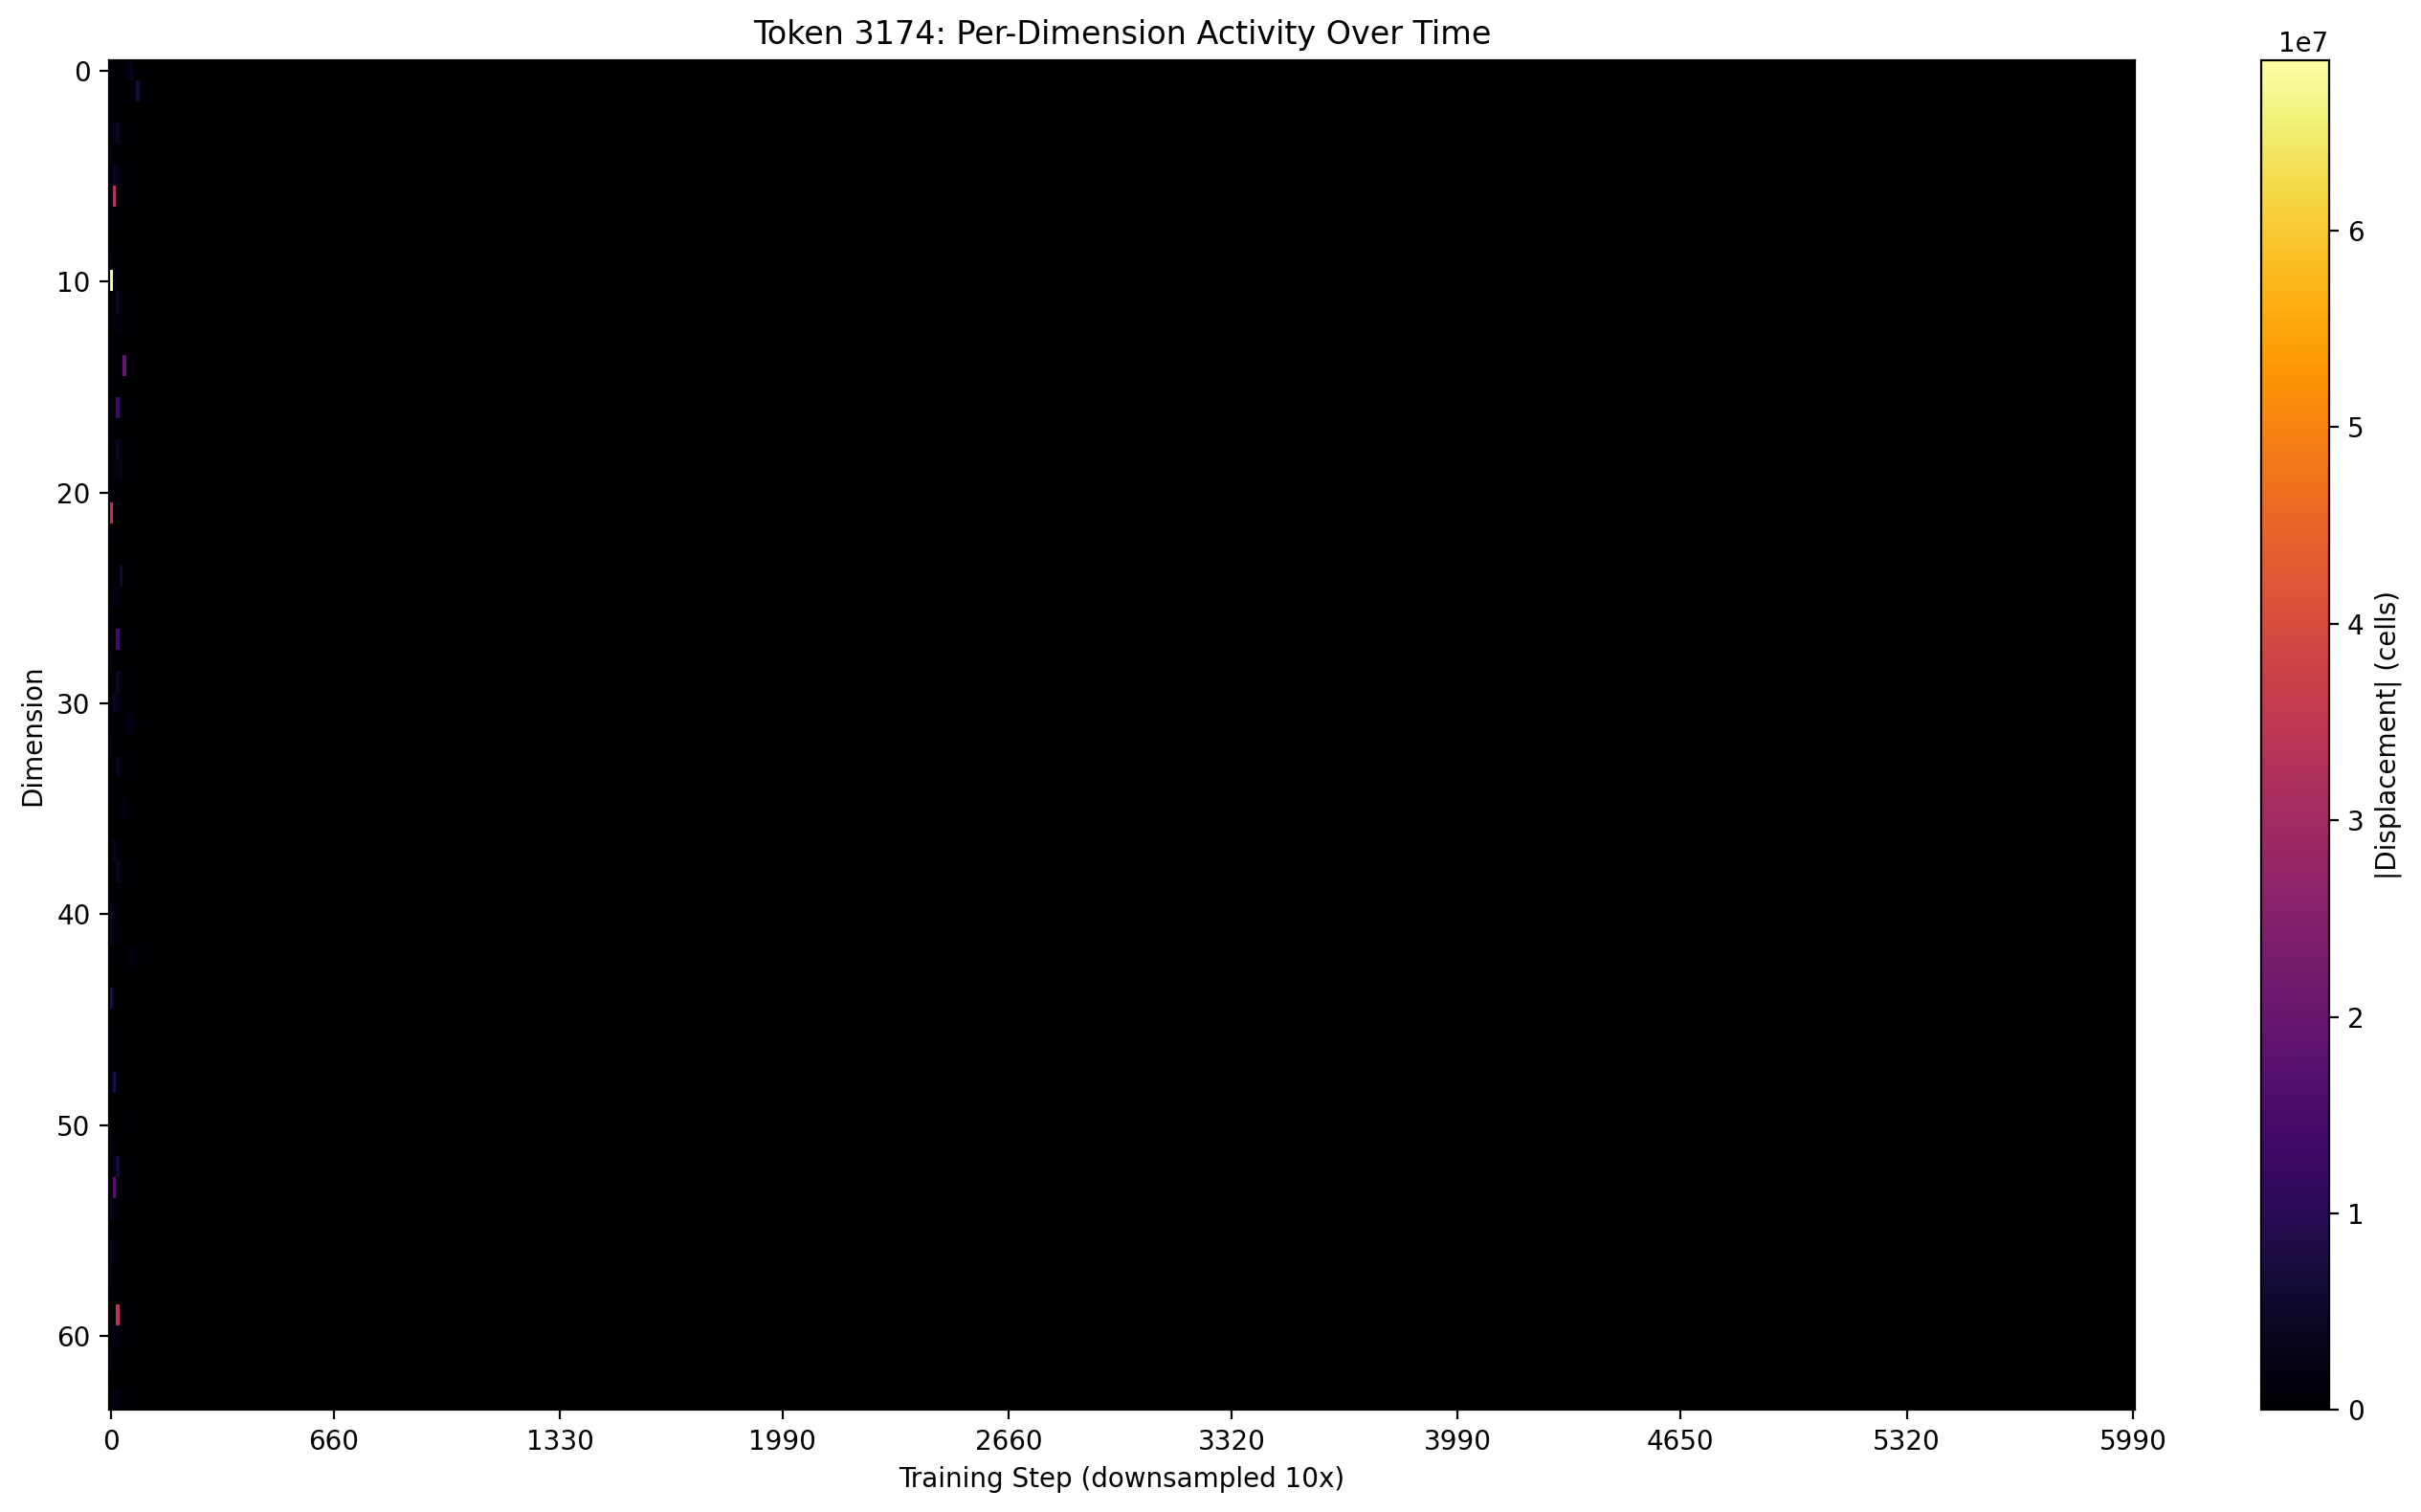

In [11]:
# Show which dimensions are active when (absolute displacement value)
# Downsample time axis for readability (every 10th step)
downsample_factor = 10
displacements_downsampled = np.abs(token_displacements[::downsample_factor, :].T)  # [64, 600]

fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

im = ax.imshow(displacements_downsampled, aspect='auto', cmap=COLORMAP, interpolation='nearest')
ax.set_xlabel('Training Step (downsampled 10x)')
ax.set_ylabel('Dimension')
ax.set_title(f'Token {token_id}: Per-Dimension Activity Over Time')

# X-axis: show actual step numbers
num_ticks = 10
tick_indices = np.linspace(0, displacements_downsampled.shape[1]-1, num_ticks, dtype=int)
tick_labels = tick_indices * downsample_factor
ax.set_xticks(tick_indices)
ax.set_xticklabels(tick_labels)

plt.colorbar(im, ax=ax, label='|Displacement| (cells)')
plt.tight_layout()
plt.show()

## Plot 5: Path Efficiency Over Time

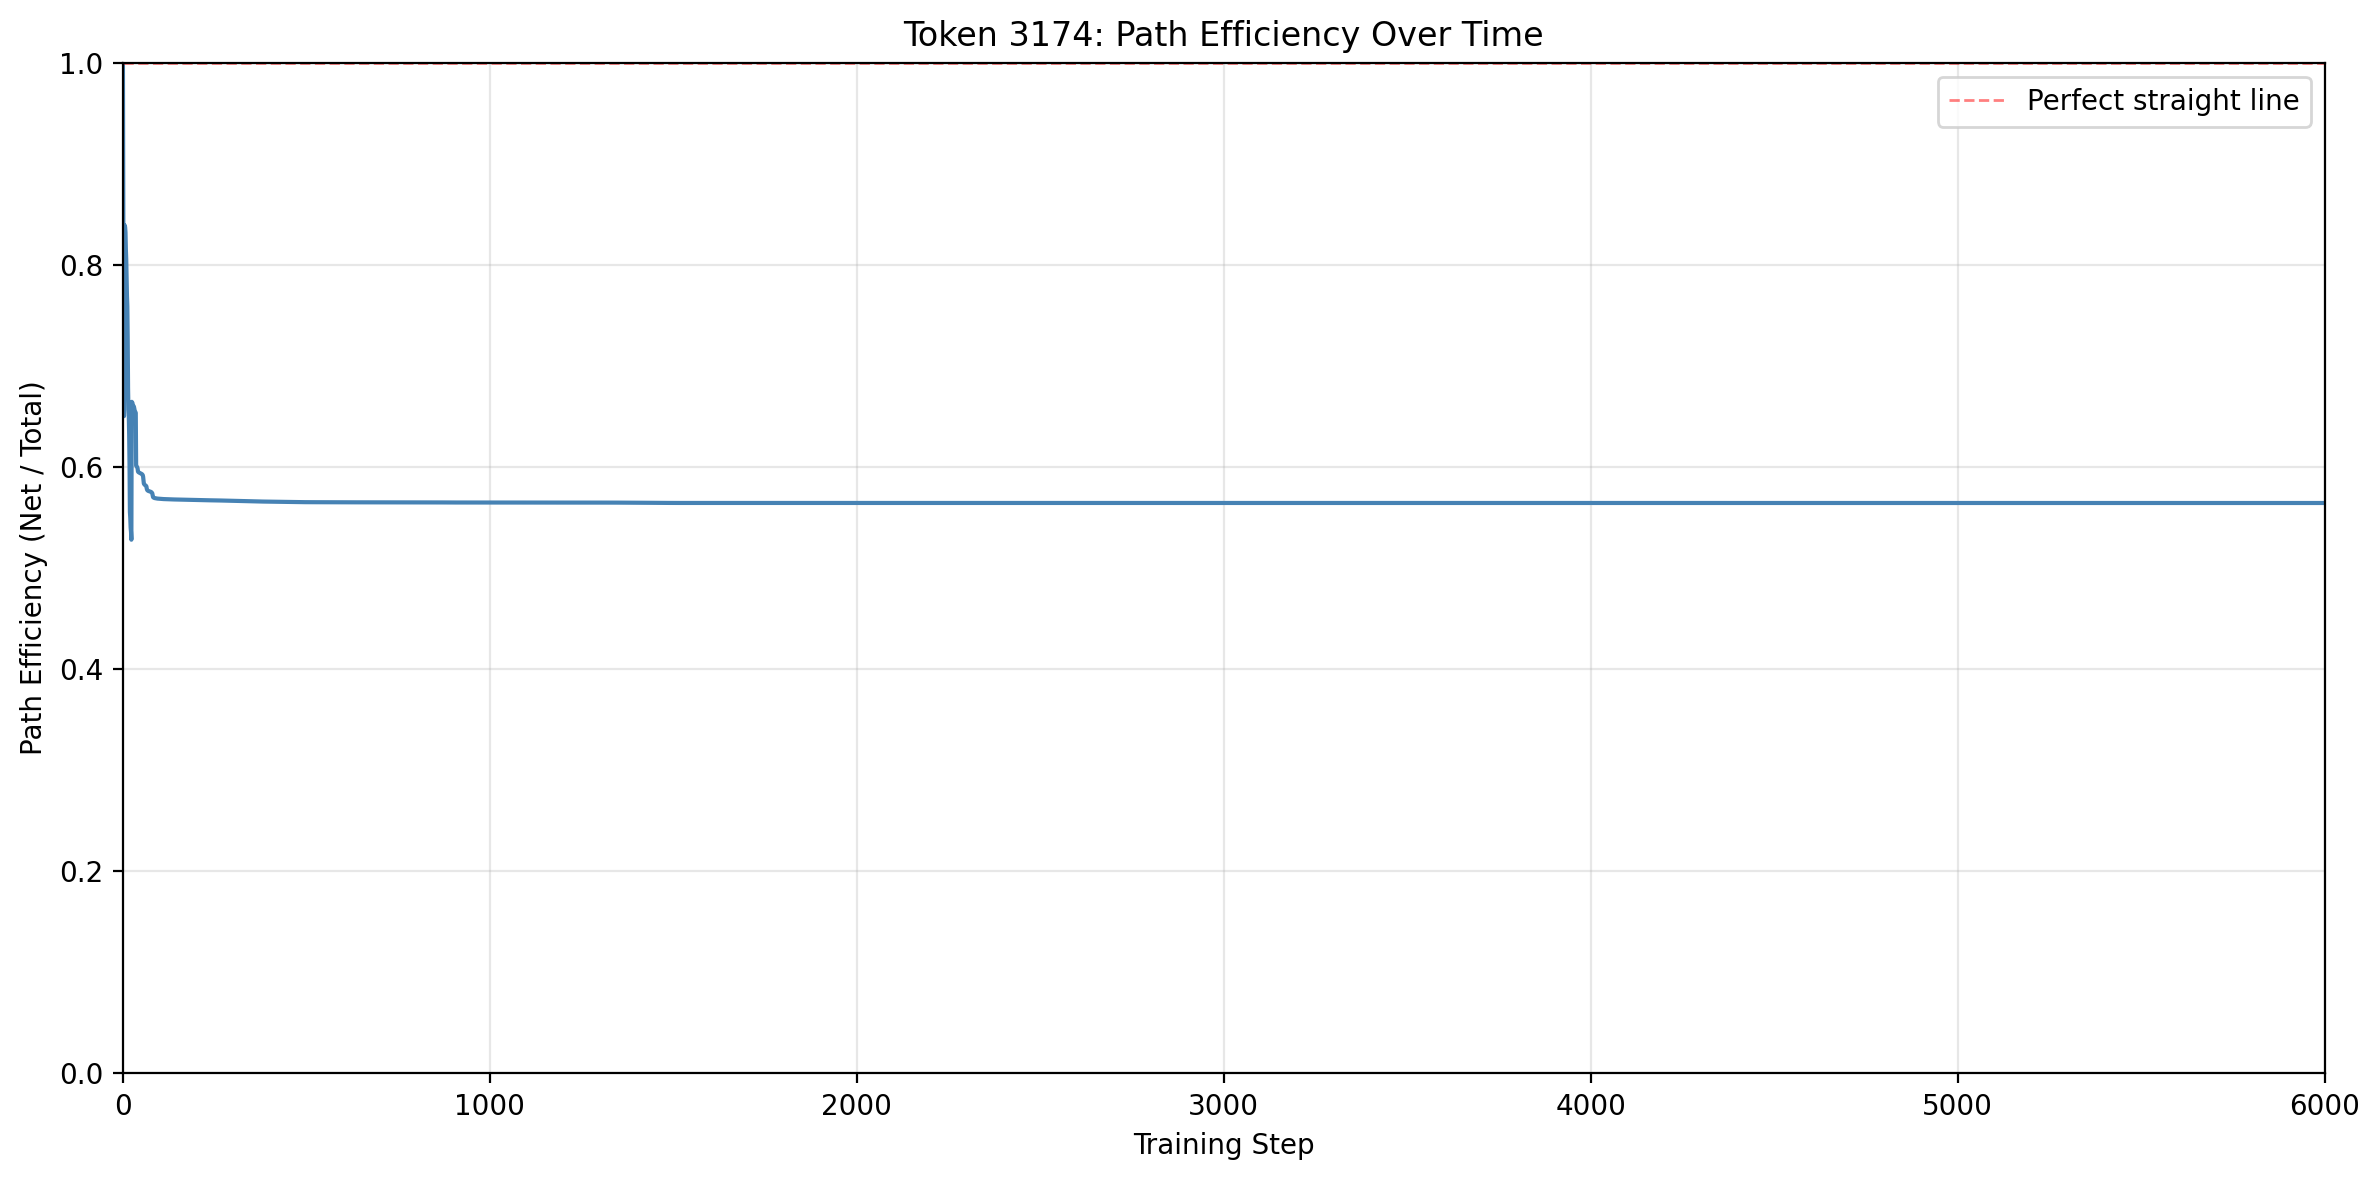

In [12]:
# Compute cumulative path efficiency at each timestep
cumulative_path_length = np.cumsum(step_size)  # [6000]
cumulative_efficiency = np.zeros(num_steps)

for t in range(num_steps):
    if cumulative_path_length[t] > 0:
        cumulative_efficiency[t] = distance_from_origin[t] / cumulative_path_length[t]

fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

ax.plot(cumulative_efficiency, color='steelblue', linewidth=1.5)

ax.set_xlabel('Training Step')
ax.set_ylabel('Path Efficiency (Net / Total)')
ax.set_title(f'Token {token_id}: Path Efficiency Over Time')
ax.set_ylim(0, 1)
ax.axhline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Perfect straight line')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
ax.set_xlim(0, num_steps)

plt.tight_layout()
plt.show()